In [3]:
!pip install tensorflow numpy matplotlib scikit-learn gradio

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gradio as gr

In [5]:
pip install markupsafe==2.0.1

Note: you may need to restart the kernel to use updated packages.


In [6]:
dataset_path = r"C:\Users\Laptop\Desktop\archive (1)\Rice_Image_Dataset"
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_data.class_indices.keys())

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [7]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=len(class_names)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_custom_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

469/469 [==============================] - 332s 705ms/step
Classification Report:
              precision    recall  f1-score   support

     Arborio       0.16      0.01      0.02      3000
     Basmati       0.22      0.04      0.06      3000
      Ipsala       0.21      0.34      0.26      3000
     Jasmine       0.21      0.21      0.21      3000
   Karacadag       0.21      0.43      0.28      3000

    accuracy                           0.21     15000
   macro avg       0.20      0.21      0.17     15000
weighted avg       0.20      0.21      0.17     15000



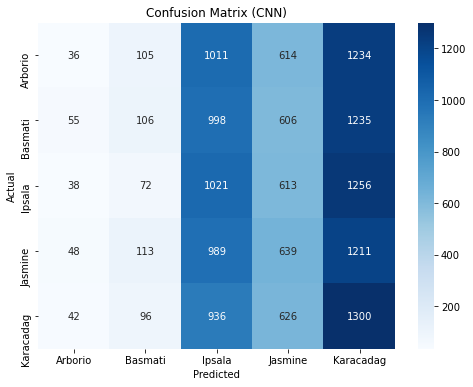

In [8]:
y_true = val_data.classes
y_pred = cnn_model.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN)')
plt.show()

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def build_transfer_model(input_shape=(224, 224, 3), num_classes=len(class_names)):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

tl_model = build_transfer_model()
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
history_tl = tl_model.fit(
    train_data,
    validation_data=val_data,
    epochs=1 
)

1875/1875 [==============================] - 1795s 955ms/step - loss: 0.0813 - accuracy: 0.9728 - val_loss: 0.0554 - val_accuracy: 0.9814


469/469 [==============================] - 82s 175ms/step
Classification Report:
              precision    recall  f1-score   support

     Arborio       0.22      0.02      0.03      3000
     Basmati       0.18      0.03      0.05      3000
      Ipsala       0.21      0.35      0.26      3000
     Jasmine       0.21      0.22      0.21      3000
   Karacadag       0.20      0.42      0.27      3000

    accuracy                           0.21     15000
   macro avg       0.20      0.21      0.17     15000
weighted avg       0.20      0.21      0.17     15000



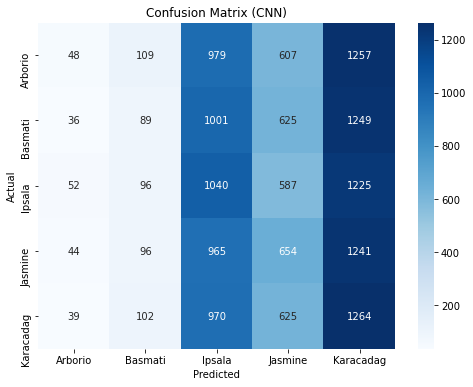

In [11]:
y_true = val_data.classes
y_pred = cnn_model.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN)')
plt.show()

In [12]:
def predict_rice_type(img):
    img = tf.image.resize(img, image_size) / 255.0
    img = tf.expand_dims(img, axis=0)
    preds = tl_model.predict(img)[0]
    return {class_names[i]: float(preds[i]) for i in range(len(class_names))}

interface = gr.Interface(
    fn=predict_rice_type,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Rice Grain Image Classification using CNN and Transfer Learning",
    description="Upload a rice grain image and get predictions using MobileNetV2."
)

interface.launch() 

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 69ms/step
